# --------------Chiến lược giao dịch theo chỉ số biến động------------------------------------------

# 1. Mã và thời gian: Du lieu cua SPY (S & P 500)

In [1]:
import pandas as pd
import yfinance as yf

symbols = ['SPY', '^GSPC', '^VIX']  # Danh sách các ký hiệu bạn muốn lấy dữ liệu
start_date = "2020-01-01"
end_date = "2023-10-18"

# 2. Load data

In [2]:

data = {}  # Tạo một từ điển để lưu trữ dữ liệu cho mỗi ký hiệu
def load_data(symbols, start_date, end_date):
    for symbol in symbols:
        data[symbol] = yf.download(symbol, start=start_date, end=end_date, interval='1d')
        data[symbol]['symbol'] = symbol
        data[symbol] = data[symbol].reset_index().rename(columns={'Adj Close': 'value', 'Date': 'date'}).sort_values(by = ['symbol', 'date'])
        data[symbol] = data[symbol][['symbol', 'date', 'value']]

    # Kết hợp dữ liệu từ các ký hiệu thành một DataFrame lớn
    dataAll = pd.concat(data.values(), ignore_index=True)

    # Pivot table dữ liệu lại
    dataAll = pd.pivot_table(dataAll, columns = 'symbol', index = 'date', values ='value')
    return dataAll


# 3. Backtest chien luoc dua vao Data tren

In [3]:

def backtest_strategy(prices, symbol_trade, symbol_volatility, volatility_threshold, capital, symbol_benchmark):      
    df_init   = (prices[symbol_trade]*0).to_frame().assign(cash = 0)
    df_update = (prices[symbol_trade]*0).to_frame().assign(cash = 0)
    df_end    = (prices[symbol_trade]*0).to_frame().assign(cash = 0)

    df_init.iloc[0, df_init.columns.get_loc('cash')] = capital
    df_end.iloc[0, df_end.columns.get_loc('cash')]   = capital

    calendar = pd.Series(prices.index).iloc[1:]
    
    for date in calendar:
        prev_date = df_init.index[df_init.index<date][-1]
        
        df_init.loc[date, :] = df_end.loc[prev_date, :]        

        port_value = df_init.loc[date, symbol_trade] * prices.loc[date, symbol_trade] + df_init.loc[date, 'cash']
        # print(port_value)
        if prices.loc[date, symbol_volatility] > volatility_threshold: # volatility is high -> be fully in cash
            df_end.loc[date, symbol_trade] = 0
            df_end.loc[date, 'cash']       = port_value
        else: # volatility is low -> be in market position
            df_end.loc[date, symbol_trade] = port_value/prices.loc[date, symbol_trade]
            df_end.loc[date, 'cash'] = 0
        df_update.loc[date] = df_end.loc[date] - df_init.loc[date]
        
    # df_update.to_csv('df_update.csv', index=True) # 'df_update.csv' là tên tệp bạn muốn lưu
    df_end.to_csv('df_end.csv', index=True) # 'df_end.csv' là tên tệp bạn muốn lưu
    # print(df_end)
    # print(prices.assign(cash = 1)[[symbol_trade, 'cash']])
    # print(df_end*prices.assign(cash = 1)[[symbol_trade, 'cash']])
    # print((df_end*prices.assign(cash = 1)[[symbol_trade, 'cash']]).sum(axis = 1).to_frame())

    portval = (df_end*prices.assign(cash = 1)[[symbol_trade, 'cash']]).sum(axis = 1).to_frame().rename(columns = {0:'strategy'})
    portval['benchmark'] = prices[symbol_benchmark]
    portval.to_csv('portval.csv', index=True) # 'portval.csv' là tên tệp bạn muốn lưu

    # portval = portval/portval.iloc[0].values    

    return portval

# 4. Chay backtest

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\PC-DELL-CU\AppData\Local\Temp\ipykernel_16412\1383042197.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9227.692140516454' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_end.loc[date, 'cash']       = port_value
C:\Users\PC-DELL-CU\AppData\Local\Temp\ipykernel_16412\1383042197.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9227.692140516454' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_update.loc[date] = df_end.loc[date] - df_init.loc[date]
C:\Users\PC-DELL-CU\AppData\Local\Temp\ipykernel_16412\1383042197.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9227.692140516454' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  

<Axes: xlabel='date'>

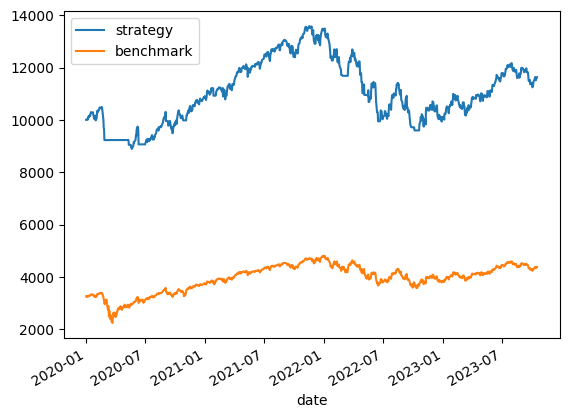

In [4]:
prices = load_data(symbols, start_date, end_date)
# print(prices)
prices.to_csv('prices.csv', index=True) # 'prices.csv' là tên tệp bạn muốn lưu

res = backtest_strategy(prices = prices, symbol_trade = 'SPY', symbol_volatility = '^VIX', volatility_threshold = 30, capital = 10000, symbol_benchmark = '^GSPC')
res.plot()